In [160]:
import numpy as np

In [162]:
from scipy.stats import norm
from scipy.stats import shapiro

In [168]:
from scipy import stats

In [3]:
from astropy.stats import sigma_clipped_stats

In [4]:
import pandas as pd

In [12]:
from scipy import stats

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from astropy.table import Table
from lsst.daf.persistence import Butler
from lsst.afw.image import PhotoCalib
from lsst import geom

path -> `/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff/v00193822-fg/R30/diffexp_00193822-g-R30-S10-det120.fits`

In [7]:
visit, detector = 193822, 120
filt = 'g'

In [8]:
#tract, patch = 4639, '0,0'
#deepCoadd_id = {'tract': tract, 'patch': patch, 'filter': filt}
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}

In [9]:
## calexp forced photometry Nanojansky
# read in the diaSrc table
diaSrc_repo = '/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect'
diaSrc_butler = Butler(diaSrc_repo)
diaSrc = diaSrc_butler.get('deepDiff_diaSrc', dataId=calexp_id)
diaSrc.getSchema().find('ip_diffim_forced_PsfFlux_instFlux').field.getUnits()

''

In [10]:
def cutout_ra_dec(butler, data_id, ra, dec, 
                   dataset_type='deepDiff_differenceExp',
                   cutout_size=75, warp_to_exposure=None, **kwargs):
    """
    Produce a cutout from dataset_type from the given butler at 
    the given ra, dec
    
    Notes
    -----
    Trivial wrapper around 'cutout_spherepoint'
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Loaded DM Butler providing access to a data repository
    data_id: Butler data ID
        E.g., {'visit': 1181556, 'detector': 45, 'filter': 'r'}
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    cutout_size: int [optional] 
        Side of the cutout region in pixels.  Region will be cutout_size x cutout_size.
    warp_to_exposure: optional
        Warp coadd to system of specified 'exposure', e.g., the visit image, to warp the coadd to
        before making the cutout.  The goal is to that a cut out of a coadd image
        and a cutout of a visit image should line up.
        'warp_to_exposure' overrides setting of 'cutout_size'.
         
    Returns
    -------
    MaskedImage
    """
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(ra, dec, geom.degrees)
   
    image = butler.get(dataset_type, dataId=data_id)

    xy = geom.PointI(image.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutout_extent//2, cutout_extent)
    
    #if warp_to_exposure is not None:
    #    warper = Warper(warpingKernelName='lanczos4')
    #    cutout_image = warper.warpExposure(warp_to_exposure.getWcs(), image,
    #                                       destBBox=warp_to_exposure.getBBox())
    #else:
    #    cutout_image = image.getCutout(radec, cutout_extent)
    cutout_image = image.getCutout(radec, cutout_extent)
    return cutout_image

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

def fit_gauss(data):
    counts, bins = np.histogram(data, density=False, bins=20)
    x = bins[:-1] + (bins[1] - bins[0])/2.
    
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, counts)
    return(g)

In [178]:
class DiffAnalyzer(object):
    
    def __init__(self, exposure, ra=None, dec=None):
        self.exposure = exposure
        
        if ra is None or dec is None:
            self.ra = np.random.uniform(lo2=100, high=4000, size=20)
            self.dec = np.random.uniform(lo2=100, high=4000, size=20)       
        else:
            self.ra = ra
            self.dec = dec
        
    def cutout(self, ra, dec, cutout_size=60):
        cutout_extent = geom.ExtentI(cutout_size, cutout_size)
        radec = geom.SpherePoint(ra, dec, geom.degrees)
        xy = geom.PointI(self.exposure.getWcs().skyToPixel(radec))
        bbox = geom.BoxI(xy - cutout_extent//2, cutout_extent)
        cutout_image = image.getCutout(radec, cutout_extent)
        return(cutout_image)
    
    def translateMask(self, mask):
        pass
    
    
    def pixeldisb(self, ra, dec, cutout_size=60):
        cutout_image = self.cutout(ra, dec, cutout_size=cutout_size)
    
        px_data = cutout_image.getImage().array
        px_vari = cutout_image.getVariance().array
        px_mask = cutout_image.getMask().array != 0 
        norm_image = px_data / np.sqrt(px_vari)
        
        # normality test
        k2, p = stats.shapiro(norm_image[px_mask].flatten())
        alpha = 0.05 # 1e-3
        print("p = {:g}".format(p))

        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected,\n inconsisten with Gaussian distribution")
        else:
            print("The null hypothesis cannot be rejected,\n consistent with Gaussian distribution")
            g = fit_gauss(norm_image[px_mask].flatten())
        
        return(p, norm_image[px_mask], g)

        

In [103]:
dataset_type = 'deepDiff_differenceExp'

In [17]:
image = diaSrc_butler.get(dataset_type, dataId=calexp_id)

In [18]:
image

In [165]:
ra  = 57.5
dec =-32.07

In [179]:
da = DiffAnalyzer(image, ra, dec)
#cutout = da.cutout(ra, dec)

In [180]:
p, data, g = da.pixeldisb(ra, dec, cutout_size=60)

p = 0.461962
The null hypothesis cannot be rejected,
 consistent with Gaussian distribution


In [181]:
stats.kstest(data, stats.norm(loc=0.0, scale=1.).cdf)

KstestResult(statistic=0.06341233459172702, pvalue=0.10849731508334388)

In [175]:
stats.kstest(data, 'norm')

KstestResult(statistic=0.06341233459172702, pvalue=0.10849731508334388)

In [185]:
stats.normaltest(data)

NormaltestResult(statistic=2.740147450587513, pvalue=0.2540882261331336)

In [183]:
mean, median, std = sigma_clipped_stats(data)

In [184]:
std**2

0.7932209596243069

In [177]:
stats.norm(loc=0.0, scale=1.).cdf

<bound method rv_frozen.cdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x2aab4c79fa90>>

In [122]:
g

<Gaussian1D(amplitude=47.66906928, mean=-0.08603752, stddev=0.85400526)>

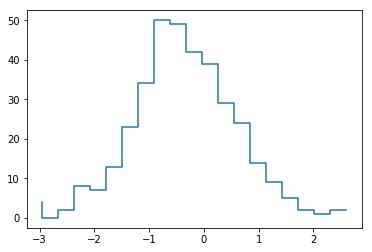

In [123]:
plt.step(bins[:-1], counts)

In [127]:
plt.hist?

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=None,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    normed=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*. The return value is a
tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
[*patches0*, *patches1*,...]) if the input contains multiple
data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays
    Input values, this takes either a single array or a sequence of
    arrays which are not re

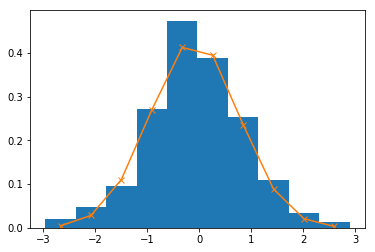

In [137]:
_, bins, _ = plt.hist(data, density=True)
x = bins[:-1] + (bins[1] - bins[0])/2.
plt.plot(x, g(x)/g(x).sum()/2*np.pi, 'x-')

In [138]:
mask = cutout.getMask()

In [148]:
np.binary_repr(mask.array[-1, -1], width=16)

'1001000000000000'

In [153]:
ff = lambda x: np.binary_repr(x, width=16)

In [154]:
ff(mask.array[-1, -1])

'1001000000000000'

In [159]:
mask.array

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 36864, 36864, 36864],
       [    0,     0,     0, ..., 36864, 36864, 36864],
       [    0,     0,     0, ..., 36864, 36864, 36864]], dtype=int32)

In [152]:
np.apply_over_axes(ff, a=mask.array, axes=[0, 1])

TypeError: <lambda>() takes 1 positional argument but 2 were given

In [39]:
mask.getMaskPlaneDict()

{'BAD': 0,
 'BRIGHT_OBJECT': 9,
 'CLIPPED': 10,
 'CR': 3,
 'CROSSTALK': 11,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INEXACT_PSF': 12,
 'INTRP': 2,
 'NOT_DEBLENDED': 13,
 'NO_DATA': 8,
 'REJECTED': 14,
 'SAT': 1,
 'SENSOR_EDGE': 15,
 'SUSPECT': 7,
 'UNMASKEDNAN': 16}

In [49]:
mask.getMaskPlane('INEXACT_PSF')

12

In [50]:
mask.getPlaneBitMask('INTRP')

4

In [51]:
def testmask(maskname):
    plane = mask.getMaskPlane(maskname)
    bit = mask.getPlaneBitMask(maskname)
    print(plane)
    print(bit)
    
    print(2**plane == bit)

In [52]:
testmask('REJECTED')

14
16384
True


In [64]:
mask.printMaskPlanes

<bound method PyCapsule.printMaskPlanes of lsst.afw.image.image.image.MaskX=[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     0     0 ... 36864 36864 36864]
 [    0     0     0 ... 36864 36864 36864]
 [    0     0     0 ... 36864 36864 36864]], bbox=(minimum=(3048, 2890), maximum=(3107, 2949)), maskPlaneDict={'BAD': 0, 'BRIGHT_OBJECT': 9, 'CLIPPED': 10, 'CR': 3, 'CROSSTALK': 11, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INEXACT_PSF': 12, 'INTRP': 2, 'NOT_DEBLENDED': 13, 'NO_DATA': 8, 'REJECTED': 14, 'SAT': 1, 'SENSOR_EDGE': 15, 'SUSPECT': 7, 'UNMASKEDNAN': 16}>

In [13]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(x)
alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 3.27207e-11
The null hypothesis can be rejected


In [26]:
da.calc_variance_test()

AttributeError: 'DiffAnalyzer' object has no attribute 'calc_variance_test'

In [21]:
cutout = cutout_ra_dec(diaSrc_butler, calexp_id, ra, dec, dataset_type='deepDiff_differenceExp', cutout_size=75)

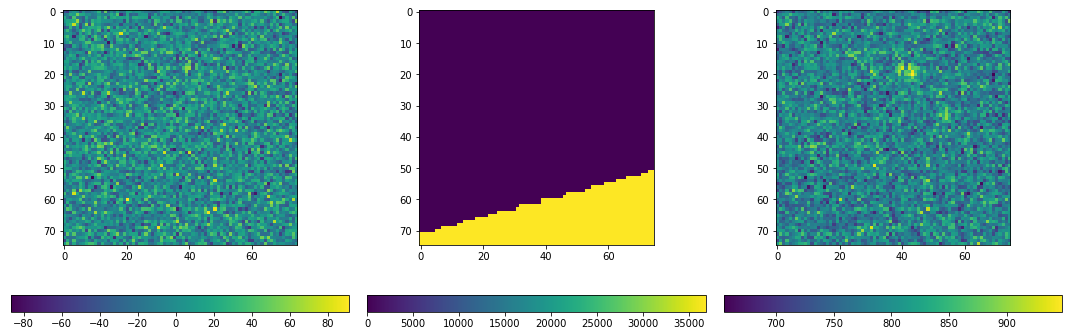

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(cutout.getImage().array)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.imshow(cutout.getMask().array)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.imshow(cutout.getVariance().array)
plt.colorbar(orientation='horizontal')
plt.tight_layout()

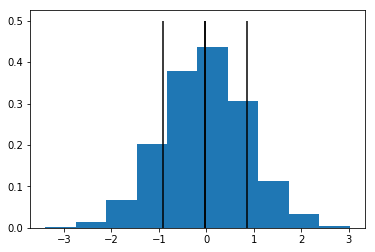

In [54]:
data = cutout.getImage().array.flatten()/np.sqrt(cutout.getVariance().array.flatten())
plt.hist(data, density=True)
mean, median, std = np.mean(data), np.median(data), np.std(data)
rmean, rmedian, rstd = sigma_clipped_stats(data)
plt.vlines(x=[mean, median, mean+std, mean-std], ymax=0.5, ymin=0.)

In [55]:
print(rmean, rmedian, rstd)

-0.029954083263874054 -0.030488375574350357 0.8693680167198181
